In [1]:
# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sdv.metadata import SingleTableMetadata
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline


In [3]:
# Load the dataset (CPT procedure codes performed during hospital admissions)
cpt = pd.read_csv('CPTEVENTS.csv.gz')

# Preview the dataset
cpt.head()

,ROW_ID,SUBJECT_ID,HADM_ID,COSTCENTER,CHARTDATE,CPT_CD,CPT_NUMBER,CPT_SUFFIX,TICKET_ID_SEQ,SECTIONHEADER,SUBSECTIONHEADER,DESCRIPTION
0,317,11743,129545,ICU,NaN,99232,99232.0,NaN,6.0,Evaluation and management,Hospital inpatient services,NaN
1,318,11743,129545,ICU,NaN,99232,99232.0,NaN,7.0,Evaluation and management,Hospital inpatient services,NaN
2,319,11743,129545,ICU,NaN,99232,99232.0,NaN,8.0,Evaluation and management,Hospital inpatient services,NaN
3,320,11743,129545,ICU,NaN,99232,99232.0,NaN,9.0,Evaluation and management,Hospital inpatient services,NaN
4,321,6185,183725,ICU,NaN,99223,99223.0,NaN,1.0,Evaluation and management,Hospital inpatient services,NaN


In [4]:

# Set multiprocessing for Windows 
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"


In [5]:
print(cpt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573146 entries, 0 to 573145
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ROW_ID            573146 non-null  int64  
 1   SUBJECT_ID        573146 non-null  int64  
 2   HADM_ID           573146 non-null  int64  
 3   COSTCENTER        573146 non-null  object 
 4   CHARTDATE         101545 non-null  object 
 5   CPT_CD            573146 non-null  object 
 6   CPT_NUMBER        573128 non-null  float64
 7   CPT_SUFFIX        22 non-null      object 
 8   TICKET_ID_SEQ     471601 non-null  float64
 9   SECTIONHEADER     573125 non-null  object 
 10  SUBSECTIONHEADER  573125 non-null  object 
 11  DESCRIPTION       101545 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 52.5+ MB
None


In [6]:
#  Check missing values
print(cpt.isnull().sum())



ROW_ID                   0
SUBJECT_ID               0
HADM_ID                  0
COSTCENTER               0
CHARTDATE           471601
CPT_CD                   0
CPT_NUMBER              18
CPT_SUFFIX          573124
TICKET_ID_SEQ       101545
SECTIONHEADER           21
SUBSECTIONHEADER        21
DESCRIPTION         471601
dtype: int64


In [7]:
#  Drop duplicates (optional)
cpt.drop_duplicates(inplace=True)


In [8]:
# Convert string dates into datetime objects
cpt['CHARTDATE'] = pd.to_datetime(cpt['CHARTDATE'])

# Verify changes
cpt.dtypes

ROW_ID                       int64
SUBJECT_ID                   int64
HADM_ID                      int64
COSTCENTER                  object
CHARTDATE           datetime64[ns]
CPT_CD                      object
CPT_NUMBER                 float64
CPT_SUFFIX                  object
TICKET_ID_SEQ              float64
SECTIONHEADER               object
SUBSECTIONHEADER            object
DESCRIPTION                 object
dtype: object

In [9]:
# Encode categorical columns
cat_cols = ['COSTCENTER', 'CPT_CD', 'SECTIONHEADER', 'SUBSECTIONHEADER']
for col in cat_cols:
    cpt[col] = cpt[col].astype('category').cat.codes



In [10]:
# Save cleaned data
cpt_cleaned = cpt.copy()
cpt_cleaned.to_csv("cpt_cleaned.csv", index=False)

In [11]:
#  Generate metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(cpt_cleaned)


In [12]:
#  Initialize synthesizer
from sdv.single_table import CTGANSynthesizer
synthesizer = CTGANSynthesizer(metadata=metadata, epochs=30)
cpt_sample = cpt_cleaned.sample(n=1000, random_state=42)




In [13]:
#  Fit model
synthesizer.fit(cpt_cleaned)

In [14]:
#  Sample synthetic data
synthetic_cpt = synthesizer.sample(num_rows=1000)
synthetic_cpt.to_csv("synthetic_cpt.csv", index=False)
print(" Synthetic data saved!")


 Synthetic data saved!


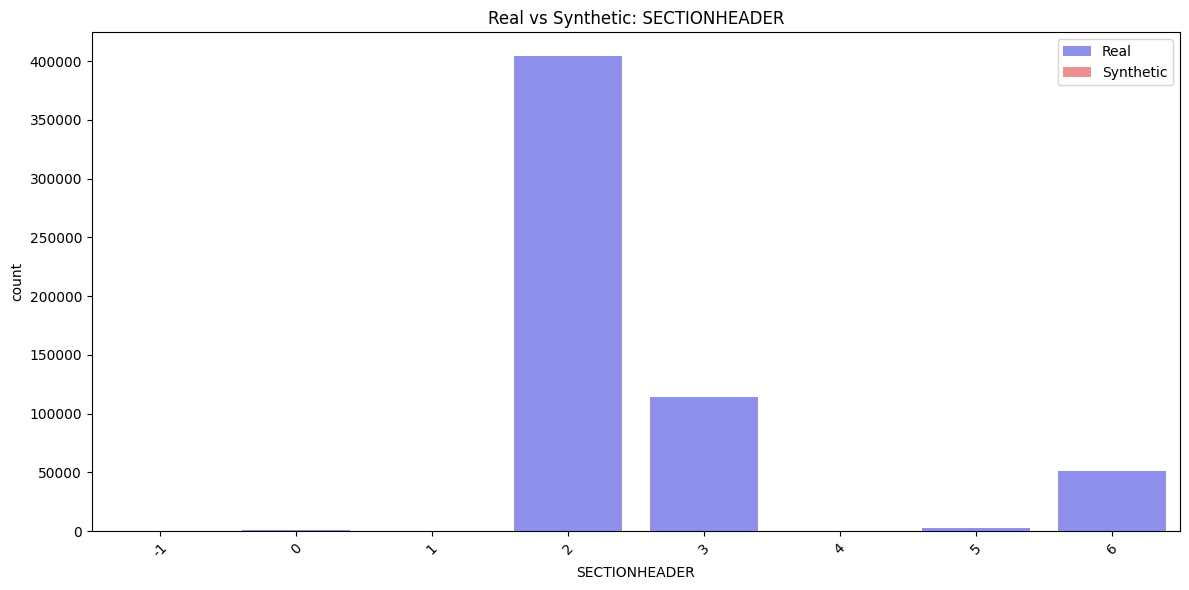

In [15]:
# Compare distributions
column = 'SECTIONHEADER'
plt.figure(figsize=(12,6))
sns.countplot(x=column, data=cpt_cleaned, color='blue', label='Real', alpha=0.5)
sns.countplot(x=column, data=synthetic_cpt, color='red', label='Synthetic', alpha=0.5)
plt.legend()
plt.title(f"Real vs Synthetic: {column}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
#  Simple model prediction example (optional)
features = ['CPT_CD', 'SECTIONHEADER', 'SUBSECTIONHEADER']
cpt_cleaned['target'] = (cpt_cleaned['SECTIONHEADER'] > cpt_cleaned['SECTIONHEADER'].median()).astype(int)
synthetic_cpt['target'] = (synthetic_cpt['SECTIONHEADER'] > cpt_cleaned['SECTIONHEADER'].median()).astype(int)

for col in features:
    cpt_cleaned[col] = cpt_cleaned[col].astype('category').cat.codes
    synthetic_cpt[col] = synthetic_cpt[col].astype('category').cat.codes

X_real = cpt_cleaned[features]
y_real = cpt_cleaned['target']
X_syn = synthetic_cpt[features]
y_syn = synthetic_cpt['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f"\n Model accuracy on real CPTEVENTS:     {real_acc:.2f}")
print(f" Model accuracy on synthetic CPTEVENTS: {syn_acc:.2f}")



 Model accuracy on real CPTEVENTS:     1.00
 Model accuracy on synthetic CPTEVENTS: 1.00


In [20]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(cpt_cleaned)


In [23]:
#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

# Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=30  # Same as CTGAN for fair comparison
)

#  Fit the VAE synthesizer
vae_synthesizer.fit(cpt_cleaned)

# Sample synthetic data using VAE
synthetic_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_vae.to_csv('synthetic_cpt_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()


,ROW_ID,SUBJECT_ID,HADM_ID,COSTCENTER,CHARTDATE,CPT_CD,CPT_NUMBER,CPT_SUFFIX,TICKET_ID_SEQ,SECTIONHEADER,SUBSECTIONHEADER,DESCRIPTION,target
0,4840957,57961,161224,0,NaT,3024,99232.0,NaN,375.0,3,23,NaN,0
1,11139396,29499,165506,0,NaT,1269,99233.0,NaN,4.0,3,23,NaN,0
2,5861604,85883,193825,0,NaT,2778,95659.0,NaN,3.0,4,29,NaN,1
3,16696004,5513,177840,1,NaT,2974,94002.0,NaN,38.0,4,47,"VENT MGMT, 1ST DAY (INVASIVE)",1
4,16606442,17297,162846,0,NaT,3022,99232.0,NaN,436.0,3,10,NaN,0


In [24]:
# Real data model
X_real = cpt_cleaned[features]
y_real = cpt_cleaned['target']  

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# VAE Synthetic data model
X_vae = synthetic_vae[features]
y_vae = synthetic_vae['target']  

Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Show results
print(f"Model accuracy on real data:           {real_acc:.2f}")
print(f"Model accuracy on VAE synthetic data:  {vae_acc:.2f}")


Model accuracy on real data:           1.00
Model accuracy on VAE synthetic data:  0.99


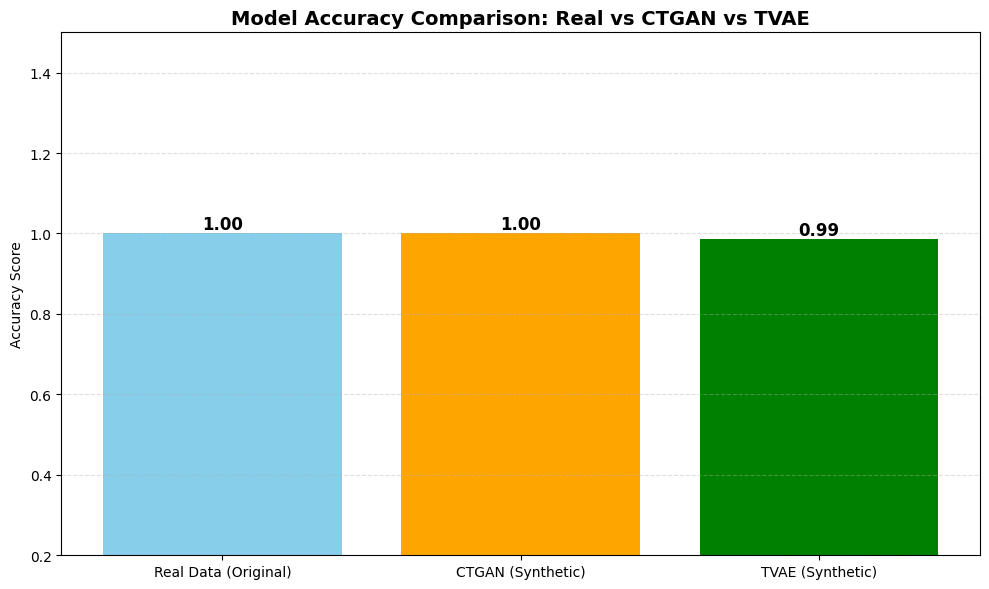

In [25]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
